# In which I brazenly defy Professor Ng and do his Bias-Variance homework in Python instead of Matlab.

Week 6 of Andrew Ng's ML course on Coursera focuses on how to properly evaluate the performance of your ML algorithm, how to diagnose various problems (like high bias or high variance), and what steps you might take for improvement. Here I use the homework data set to learn about the relevant python tools.

>## Tools Covered:
- `SGDRegressor` for linear regression specifying a loss and penalty and fit using gradient descent
- `learning_curve` for generating diagnostic plots of score vs. training size
- `validation_curve` for generating diagnostic plots of score vs. meta-parameter value
- also `PolynomialFeatures` for getting higher order transforms of features and `StandardScaler` for normalizing features


# Visualizing the Data

*In the first half of the exercise, you will implement regularized linear regression to predict the amount of water 
flowing out of a dam using the change
of water level in a reservoir.*

In [18]:
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
import pandas as pd
import numpy as np
import snips as snp
snp.prettyplot(matplotlib)

In [3]:
cd hw-wk6

C:\Users\Sonya\Box Sync\Projects\course-machine-learning\hw-wk6


Let's use a super convenient scipy module that lets you read in Matlab files and gives you back a dictionary object whose keys are the "names" of the variables.

In [9]:
matlab_vars = scipy.io.loadmat("ex5data1.mat")
matlab_vars.keys()

dict_keys(['Xval', 'Xtest', 'ytest', '__header__', '__globals__', '__version__', 'yval', 'y', 'X'])

In [32]:
matlab_vars["X"]

array([[-15.93675813],
       [-29.15297922],
       [ 36.18954863],
       [ 37.49218733],
       [-48.05882945],
       [ -8.94145794],
       [ 15.30779289],
       [-34.70626581],
       [  1.38915437],
       [-44.38375985],
       [  7.01350208],
       [ 22.76274892]])

One caveat with `loadmat` is that it usually gives you these kinds of arrays of arrays. This is actally the format that most `sklearn` classes expect for your input features $X$ (a true matrix, an array of arrays). On the other hand it expects a simple one-dimensional array of *values* for the $y$ input. Since you'll get some annoying warnings later if you don't deal with this, let's use the super userful `numpy` function `ravel` which "unravels" higher dimension data structures in order to flatten them down to a single one-dimensional array o values

In [51]:
np.ravel(matlab_vars["y"])

array([  2.13431051,   1.17325668,  34.35910918,  36.83795516,
         2.80896507,   2.12107248,  14.71026831,   2.61418439,
         3.74017167,   3.73169131,   7.62765885,  22.7524283 ])

Much better. Now lets read in all the variables and flatten them. 

In [56]:
X = matlab_vars["X"]
Xval = matlab_vars["Xval"]
Xtest = matlab_vars["Xtest"]

y = np.ravel(matlab_vars["y"])
yval = np.ravel(matlab_vars["yval"])
ytest = np.ravel(matlab_vars["ytest"])

In [89]:
# For future use I"ll want all this data together
X_all = np.concatenate([X, Xval, Xtest])
y_all = np.concatenate([y, yval, ytest])

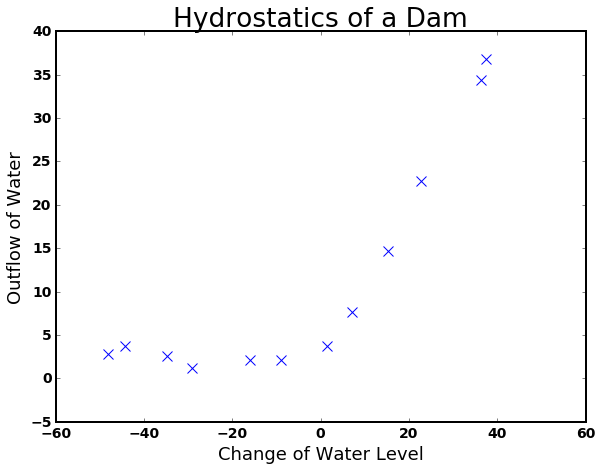

In [57]:
fig, ax = snp.newfig()
snp.labs("Change of Water Level", "Outflow of Water", "Hydrostatics of a Dam")
ax.scatter(X, y, s=100, marker="x")

# First Order Linear Model, No Regularization
Obviously this is going to suck, but let's do it anyway. So our $X$ is one-dimensional i.e. our model has a single feature, thus linear regression is going to fit a straight line with two parameters, slope and intercept. 

In [310]:
from sklearn.linear_model import LinearRegression, SGDRegressor
regressor = SGDRegressor(loss="squared_loss", penalty="none")  # No regularization means no penalty
regressor.n_iter = np.ceil(10**6 / len(y))  # Remember, this parameter is dumb out-of-the-box.

In [225]:
X = X.reshape(-1, 1)  # It expects a very particular form of input matrix. 
regressor.fit(X, y) 

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=83334.0, penalty='none', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

Easy enough. Let's look a little closer at the fitted model.

In [226]:
print(regressor.coef_, regressor.intercept_)

[ 0.29312285] [ 13.34276579]


In [227]:
# Get a set of predictions for plotting
x_pred = np.arange(min(X), max(X), len(X)/3).reshape(-1, 1)
y_pred = regressor.predict(x_pred)

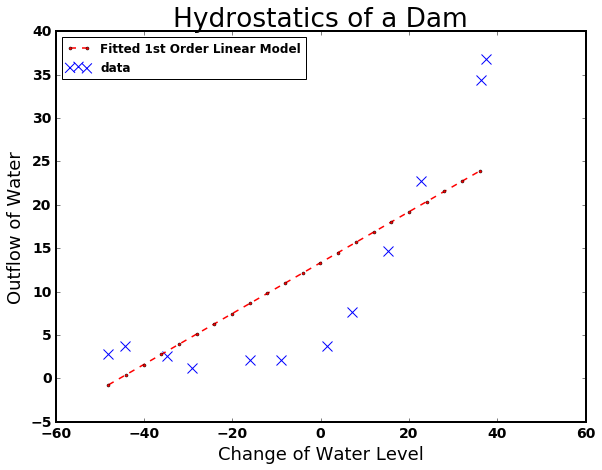

In [228]:
fig, ax = snp.newfig()
snp.labs("Change of Water Level", "Outflow of Water", "Hydrostatics of a Dam")
ax.scatter(X, y, s=100, marker="x", label="data")
ax.plot(x_pred, y_pred, linestyle="--", color="r", label="Fitted 1st Order Linear Model")
ax.legend(loc="upper left")

# Bias and Variance in Procedures
When your model doesn't generalize well you most likely have an underfitting problem (high bias) or overftting problem (high variance), and identifying which one can guide how you iterate on your model.

In underfitting, your procedure is not sufficiently responsive or sensitive to training data - it has a "bias" towards always landing on the same hypothesis regardless of the training data. This could be that the form of the model is not sufficiently complex so that it's simply not capable of capturing relationships among the input features. Another possibility is that you are regularizing too strongly and forcing the fit towards some constant. 

In overfitting your procedure is instead *too* sensitive to the training points and so the specific fitted hypothesis can vary wildly with small changes in the training set. This can result from a model form that is very complex and thus tends to capture behavior in the training data that is in reality just random noise. 


# Learning Curves For Diagnosing Bias and Variance

Learning curves are an excellent way of diagnosing high bias or high variance issues with a particular procedure. First recall that all algorithms fit a model by minimizing some cost function, $J$, over the parameter space. Now imagine you have split your data into training and CV subsets. How will $J_\textrm{train}$ and $J_\textrm{CV}$ change if you were fit your model starting with just a single point in the training set and then progressively using more points in the training set to fit? Since it is easy to fit on one or two points we expect $J_\textrm{train}$ to start low, but then it should increase as we add more points into the fitting procedure and hopefully begin to flatten out. On the other hand, since we are probably not getting a very *good* estimate of parameters by using only one or two training points, we expect $J_\textrm{CV}$ to start high, and hopefully decrease as we use more and more training points for the fit. **This plot of $J_\textrm{train}$ (calculated on the truncated training set) and $J_\textrm{CV}$ (calculated on the full CV set) as a function of size of the truncated training set, $m_\textrm{train}$, is a Learning Curve.**

How to interpret these curves? If your specific hypothesis has high bias, then it can't support a sufficiently complex decision boundary *regardless* of how many points you use in fitting - thus $J_\textrm{CV}$ tends to flatten out quickly and not decrease with increasing $m_\textrm{train}$. $J_\textrm{CV}$ will also probably flatten to a value close to $J_\textrm{train}$ since high "bias" means the model's output is relatively insensitive to the particular set of input points. Conversely, overfitting manifests as a large $J_\textrm{CV}$ which decreases slowly with $m_\textrm{train}$, though it will look like the two losses would converge if extrapolated out to very large number of training points.

Note that all of this could be cast in terms of whatever performance metric you desire - it doesn't have to be loss. You could instead plot 0-1 misclassification error, F1 score, $R^2$ etc., the same ideas will hold. 


# Learning Curves in scikit-learn
Since `sklearn` is the best package that ever existed, for anything, ever... it of course has a built in Learning Curve function. Definitely take a look at the [official docs for learning curves](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html), and also this [helpful example of plotting a learning curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html). There is also a nice set of articles on [general advice on bias/variance in ML](http://www.astroml.org/sklearn_tutorial/practical.html) on the official `sklearn` pages.

The `learning_curve` function needs to be provided with your full data set ($X$ and $y$), it then handles chunking up the data into training and cross-validation sets. You also need to pass an `estimator` object which has both `fit` and `predict` methods implemented. The outputs of `learning_curve` are the sizes of the truncated training set, the training error achieved for fits with those subsets, and the cross-validation error achieved from fits with those subsets.

In [229]:
from sklearn.model_selection import learning_curve
train_sz, train_errs, cv_errs = learning_curve(estimator=regressor, X=X_all, y=y_all)  # Use our estimator object from above

Take a look at the returned training sizes and one of these error objects. 

In [230]:
train_sz

array([ 3, 11, 19, 27, 36])

In [231]:
train_errs

array([[ 0.84119828,  0.97219082,  0.97227377],
       [ 0.75427542,  0.61273632,  0.58214486],
       [ 0.60832957,  0.6886608 ,  0.62615467],
       [ 0.51797534,  0.67606686,  0.69145057],
       [ 0.54851897,  0.68476497,  0.66463945]])

You can see that it defaulted to looking at 5 increasingly large subsets of the training data. Each one of those subsets gets a row in the error object - but you might be wondering why there isn't just a single number (the "error") for each subset. The reason is that this function is doing *K-folds Cross-Validation*


## K-folds Cross-Validation for Smother LCs
Say you want a train/CV split of 75% / 25%. You could randomly choose 25% of the data and call that your one and only cross-validation set and run your relevant metrics with it. To get more robust results though, you might want to repeat this procedure, but with a different chunk of data as the cross-validation set. Then you could average the resulting metrics. **In K-Folds cross-validation you evenly split your data set into $k$ non-overlapping pieces and use each piece in turn as the cross-validation set (the other $k-1$ pieces serve as the training set). You then average all the relevant results over the $k$ trials.** 

So this explains the above mystery - the default of `learning_curve` is to use the very common 3-fold cross validation protocol so that it has 3 non-overlapping sets to compute cross-validation error on. You can specify $k$ in `learning_curve` with the kwarg `cv`. This means that what we really want to plot is the average error within each row of `train_errors`.

In [232]:
tr_err = np.mean(train_errs, axis=1)
cv_err = np.mean(cv_errs, axis=1)

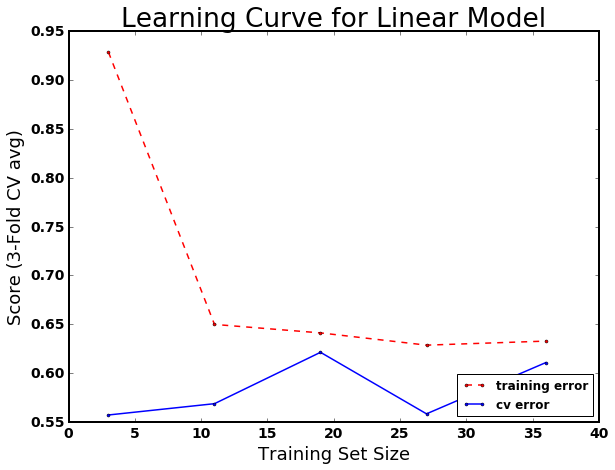

In [233]:
fig, ax = snp.newfig()
snp.labs("Training Set Size", "Score (3-Fold CV avg)", "Learning Curve for Linear Model")
ax.plot(train_sz, tr_err, linestyle="--", color="r", label="training error")
ax.plot(train_sz, cv_err, linestyle="-", color="b", label="cv error")
ax.legend(loc="lower right")

## Model Scoring - the Y-axis of the LC
These y-values might look strange to you. Recall that Learning Curves can plot any metric that you care about, like loss, misclassification error or F1 score. When you run `learning_curves` you can specify what is should plot with the `scoring` kwarg, if you don't it will try to use the `score` method of you estimator. Most sklearn algorithm classes will have this method defined - in this case `SGDRegressor`score method computes the $R^2$ score so that is what we are plotting. The sklearn official docs has a great [tutorial on model scoring](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

The `scoring` kwarg has several strings which cover the most common metrics, but if you want to pass something special then it should be a function of the form `scorer(estimator, X, y)`. Let's try this with the default `"neg_mean_squared_error"` score which is exactly what it sounds like (zero is good, large and negative is bad).

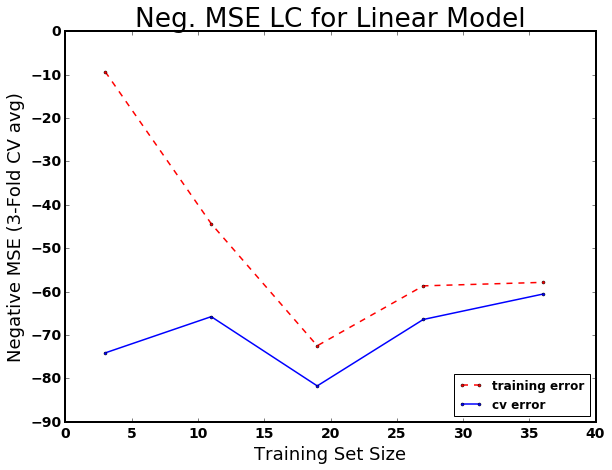

In [234]:
train_sz, train_errs, cv_errs = learning_curve(estimator=regressor, X=X_all, y=y_all, scoring="neg_mean_squared_error")

tr_err = np.mean(train_errs, axis=1)
cv_err = np.mean(cv_errs, axis=1)

fig, ax = snp.newfig()
snp.labs("Training Set Size", "Negative MSE (3-Fold CV avg)", "Neg. MSE LC for Linear Model")
ax.plot(train_sz, tr_err, linestyle="--", color="r", label="training error")
ax.plot(train_sz, cv_err, linestyle="-", color="b", label="cv error")
ax.legend(loc="lower right")

## Finer Spacing of Set Sizes, Higher k-folds
Let's get a more finely graded curve by specifying the kwarg `train_sizes` which dictates the sizes of the training subsets. Note you can also pass it fractions (of the full training set) rather than absolute sizes. Also we can change to 5-fold cross validation with the `cv` kwarg.

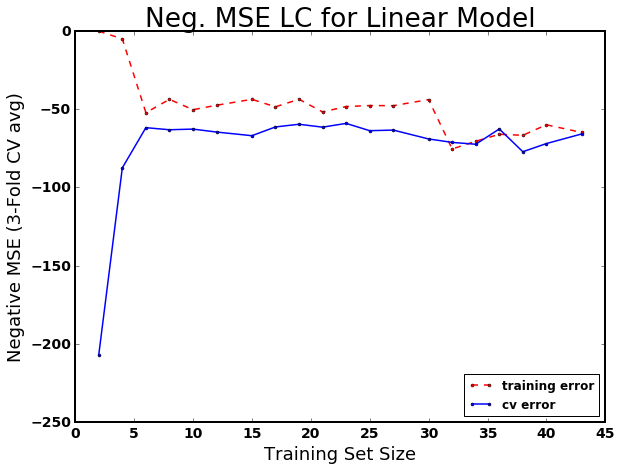

In [235]:
train_sz, train_errs, cv_errs = learning_curve(estimator=regressor, X=X_all, y=y_all, 
                                               cv=5, train_sizes=np.linspace(0.05, 1, 20), 
                                               scoring="neg_mean_squared_error")

tr_err = np.mean(train_errs, axis=1)
cv_err = np.mean(cv_errs, axis=1)

fig, ax = snp.newfig()
snp.labs("Training Set Size", "Negative MSE (3-Fold CV avg)", "Neg. MSE LC for Linear Model")
ax.plot(train_sz, tr_err, linestyle="--", color="r", label="training error")
ax.plot(train_sz, cv_err, linestyle="-", color="b", label="cv error")
ax.legend(loc="lower right")

## Interpreting the LC
This LC is very informative. After using all our training data the model is doing about the same on the CV set as on the training set - that means we don't have overfitting (the model generalized very well). On the other hand in absolute terms the error is high for CV and train, and the curves flattened out very quickly which means our hypothesis didn't change much with the addition of more and more points. Both of those things scream underfitting. Of course you already knew that a straight line would underfit :)


# Learning Curves with Overfitting
To avoid underfitting (high bias) one option is to add polynomial transforms of our features in order to achieve a more complex hypothesis form. Let's try it out using automated higher-order feature creation with the `PolynomialFeatures` class. 

In [331]:
# Make our new matrix of features with higher order terms
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(6)  # Will create features up to 6 degrees
polyX = poly.fit_transform(X)

Here it becomes very important to standardize all your features to facilitate the gradient descent minimization algorithm - we can do that with another nice tool called `StandardScaler`.

In [332]:
# Scale our features to facilitate gradient descent minimization.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(polyX)  # Train the transformer object so it knows what means and variances to use
polyX_transform = scaler.transform(polyX)  # transform your training data in preparation for some badass ML algorithm

In [333]:
# Fit the linear model with the added features
regressor.n_iter = np.ceil(10**6 / len(y))
regressor.fit(polyX_transform, y)

SGDRegressor(alpha=1000, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=83334.0, penalty='none', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [334]:
# Make some predictions from the polynomial model
xs = np.linspace(-60, 60, 120).reshape(-1, 1)
Xpred = poly.fit_transform(xs)
Xpred = scaler.transform(Xpred)

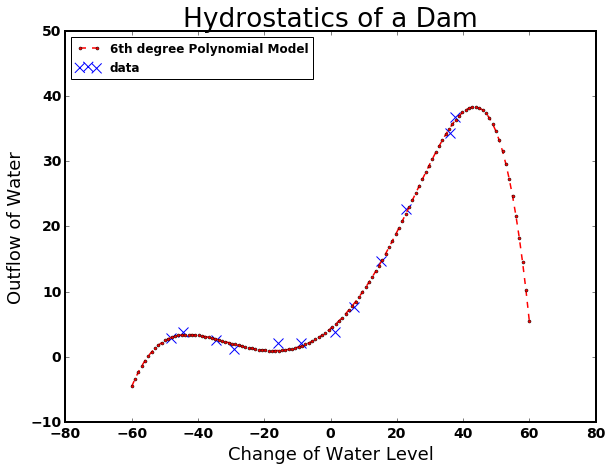

In [335]:
# Plot the data and the predictions
fig, ax = snp.newfig()
snp.labs("Change of Water Level", "Outflow of Water", "Hydrostatics of a Dam")
ax.scatter(X, y, s=100, marker="x", label="data")
ax.plot(xs, regressor.predict(Xpred), linestyle="--", color="r", label="6th degree Polynomial Model")
ax.legend(loc="upper left")

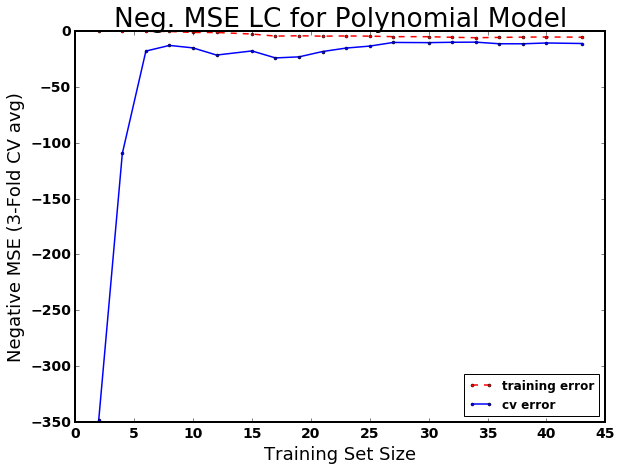

In [343]:
xall = poly.fit_transform(X_all)
xall = scaler.transform(xall)

regressor.penalty="None"
train_sz, train_errs, cv_errs = learning_curve(estimator=regressor, X=xall, y=y_all, 
                                               cv=5, train_sizes=np.linspace(0.05, 1, 20), 
                                               scoring="neg_mean_squared_error")

tr_err = np.mean(train_errs, axis=1)
cv_err = np.mean(cv_errs, axis=1)

fig, ax = snp.newfig()
snp.labs("Training Set Size", "Negative MSE (3-Fold CV avg)", "Neg. MSE LC for Polynomial Model")
ax.plot(train_sz, tr_err, linestyle="--", color="r", label="training error")
ax.plot(train_sz, cv_err, linestyle="-", color="b", label="cv error")
ax.legend(loc="lower right")

Here we see that the error on the training set begins and remains extremely low, while the error on the cross validation set is getting lower with more and more data points. This is characteristic of overfitting, although the effect is not very strong here - if it were then the CV error would plateau at a much higher value as an overfitted model fails to generalize well. If we were to add in regularization to the fitting algorithm then we could suppress the remaining variance issue, but the question is how to select the best regularization strength?

# Validation Curves for Assessing Meta Parameter Values
Things like regularization strength and polynomial degree are often called meta parameters of your model, and they are typically "fit" by trying different values and choosing the ones which minimize the cross-validation error. This leads us to another very useful diagnostic tool: **a Validation Curve plots the training and CV error as you vary a meta parameter.** As with the Learning Curve, the y-axis of these plots can really be any metric that you care about. Naturaly sklearn has a tool for this.

In [362]:
regressor.penalty = "l2"

from sklearn.model_selection import validation_curve
alphas = np.logspace(-3, 0, 20)  # The different regularization strengths to try
train_scores, cv_scores = validation_curve(regressor, xall, y_all, 
                                           param_name="alpha", param_range=alphas, 
                                           scoring="neg_mean_squared_error")

Just like with `learning_curve` the default is to do 3-fold cross-validation (which you can change using the `cv` kwarg), and you average the results at each meta-parameter value to give you a smoother idea of the behavior. Also notice that like the `learning_curve` function, you can decide what goes on the y-axis with the `scoring` kwarg.

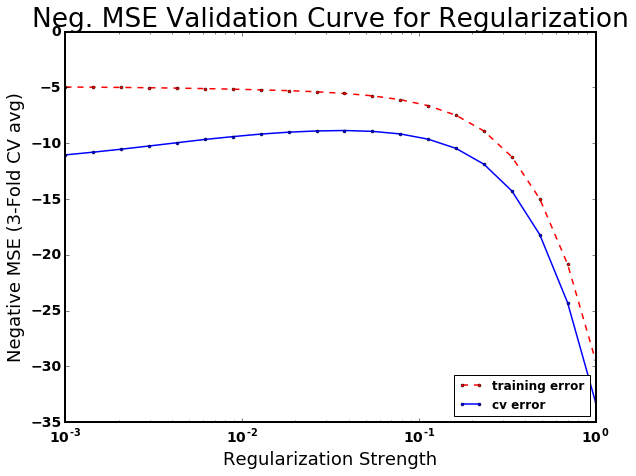

In [364]:
tr_err = np.mean(train_scores, axis=1)
cv_err = np.mean(cv_scores, axis=1)

fig, ax = snp.newfig()
snp.labs("Regularization Strength", "Negative MSE (3-Fold CV avg)", "Neg. MSE Validation Curve for Regularization")
ax.plot(alphas, tr_err, linestyle="--", color="r", label="training error")
ax.plot(alphas, cv_err, linestyle="-", color="b", label="cv error")
ax.set_xscale("log")
ax.legend(loc="lower right")

In [368]:
alphas[np.argmax(cv_err)]

0.037926901907322501

It looks like a regularization strength around 0.38 will do best. This was simple enough with just regularization strength, but with several meta-parameters your validation curve lives in a high-dimensional meta-parameter-space. The `GridSearch` and `pipeline` tools are designed for those situations where you want to minimize the cross-validation error over several different meta parameters. I'll dig into those at a later time. 

# Summary
A **Learning Curve** is a plot of $J_\textrm{train}$ (calculated on a truncated training set) and $J_\textrm{CV}$ (calculated on the full cross-val set) as a function of $m_\textrm{train}$ (the size of the truncated training set). In Learning Curves underfitting manifests as $J_\textrm{CV}$ flattening out quickly at something close to $J_\textrm{train}$, while overfitting manifests as a large $J_\textrm{CV}$ which decreases slowly, with a large gap from $J_\textrm{train}$ though it will look like the two losses would converge if extrapolated out. You can use `learning_curve` to generate these values, you just need to pass it an estimator object and your data. 

A **Validation Curve** is similar, it plots $J_\textrm{train}$ and $J_\textrm{CV}$ but as you vary a meta-parameter of your model, such as regularization strength. You can use `validation_curve` to generate these values, you just need to pass it an estimator object, your data, and the name of the estimators parameter that you would like vary along with the values it should take.